# Image Captioning

This is the project for Deep Learning using Tensorflow: [Project Proposal](https://sharedcare.io/ImageCaptioning/proposal/)

# Prepare the Training Data
##### Location to save the MSCOCO data.
MSCOCO_DIR="data/mscoco"

##### Run the preprocessing script.
sh ./download_and_preprocess_mscoco.sh \${MSCOCO_DIR}

##### Build the vocabulary.
DATA_DIR="mscoco/raw-data"

OUTPUT_DIR="mscoco/output"

python build_mscoco_data.py --train_image_dir=\${DATA_DIR}/train2014/ --val_image_dir=\${DATA_DIR}/val2014/ --train_captions_file=\${DATA_DIR}/annotations/captions_train2014.json --val_captions_file=\${DATA_DIR}/annotations/captions_val2014.json --output_dir=\${OUTPUT_DIR}/ --word_counts_output_file=\${OUTPUT_DIR}/word_counts.txt


# Download the Inception v3 Checkpoint
##### Location to save the Inception v3 checkpoint.
INCEPTION_DIR="data"

mkdir -p ${INCEPTION_DIR}

wget "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"

tar -xvf "inception_v3_2016_08_28.tar.gz" -C ${INCEPTION_DIR}

rm "inception_v3_2016_08_28.tar.gz"

# Train a Model
##### Directory containing preprocessed MSCOCO data.
MSCOCO_DIR="data/data/mscoco"

##### Inception v3 checkpoint file.
INCEPTION_CHECKPOINT="data/inception_v3.ckpt"

##### Directory to save the model.
MODEL_DIR="model"

##### Train the model.
(tensorflow) device:im2txt user\$ python train.py --input_file_pattern="\${MSCOCO_DIR}/train-?????-of-00256" --inception_checkpoint_file="\${INCEPTION_CHECKPOINT}" --train_dir="\${MODEL_DIR}/train" --train_inception=false --number_of_steps=1000000

##### ＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿ Divider ＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿

# Using pre-trained models
First, we need to extract the tag from image using image recognition network.
Hence, we use [Interception V4](http://arxiv.org/abs/1602.07261) model for this project. To fit our purpose, we need use pre-trained models.
The code for train a Interception V4 model is avaliable [here](https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v4.py) and the pre-trained model is avaliable [here](http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz).

### Download the Inception V4 checkpoint

In [7]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz"
checkpoints_dir = './tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v4_2016_09_09.tar.gz 99.7%

### Apply Pre-trained Inception V4 model to Images.

### Conclusion on Interception V4
As we apply the Interception V4 model to a image, we can get the tags with probabilities describing specific image. In this case, we can use this model to train our actual image captioning model.

INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


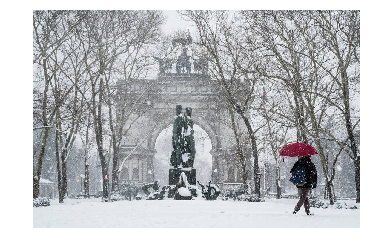

Probability 99.83% => [umbrella]
Probability 0.03% => [fountain]
Probability 0.00% => [trench coat]
Probability 0.00% => [bell cote, bell cot]
Probability 0.00% => [triumphal arch]


In [3]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception_v4
from nets.inception_v4 import inception_v4
from nets.inception_v4 import inception_v4_arg_scope
from nets.inception_v4 import inception_v4_base
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception_v4.default_image_size

with tf.Graph().as_default():
    # Get image from url
    url = 'https://static01.nyt.com/images/2018/04/02/nyregion/02nytoday1/02nytoday1-master768.jpg'
    image_string = urllib.urlopen(url).read()
    
    # Get image from local
    # image_dir = './flickr8k/Flicker8k_Dataset/10815824_297e03d76.jpg'
    # image_file = open(image_dir, 'rb')
    # image_string = image_file.read()
    # image_file.close()
    
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Process and apply the pre-trained model on the image   
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    # Shape of processed_image is (image_size, image_size, 3)
    processed_images  = tf.expand_dims(processed_image, 0)
    # Shape of processed_images is (1, image_size, image_size, 3)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v4_arg_scope()):
        # Get prediction of the model
        logits, _ = inception_v4(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v4.ckpt'),
        slim.get_model_variables('InceptionV4'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


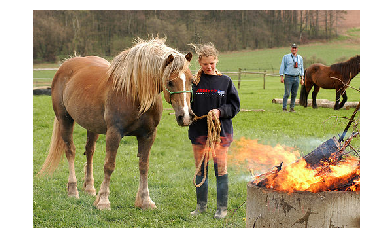

Probability 29.91% => [sorrel]
Probability 11.55% => [barrel, cask]
Probability 10.28% => [caldron, cauldron]
Probability 3.30% => [plow, plough]
Probability 3.00% => [rain barrel]
INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


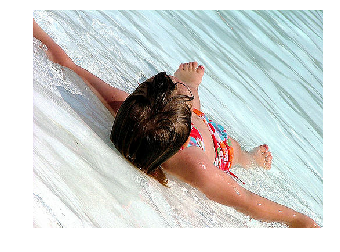

Probability 58.47% => [bikini, two-piece]
Probability 14.52% => [maillot]
Probability 6.01% => [maillot, tank suit]
Probability 4.19% => [swimming trunks, bathing trunks]
Probability 2.19% => [tub, vat]
INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


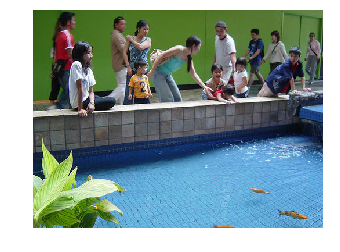

Probability 48.68% => [sea lion]
Probability 14.58% => [killer whale, killer, orca, grampus, sea wolf, Orcinus orca]
Probability 4.97% => [swimming trunks, bathing trunks]
Probability 3.28% => [fountain]
Probability 2.20% => [bathing cap, swimming cap]
INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


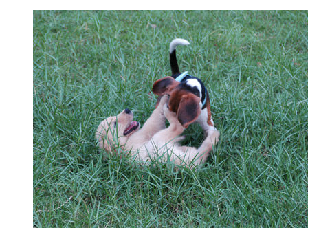

Probability 84.71% => [beagle]
Probability 7.16% => [Walker hound, Walker foxhound]
Probability 1.02% => [English foxhound]
Probability 0.52% => [bluetick]
Probability 0.41% => [basset, basset hound]


In [5]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
from datasets import imagenet
from nets import inception_v4
from nets.inception_v4 import inception_v4
from nets.inception_v4 import inception_v4_arg_scope
from nets.inception_v4 import inception_v4_base
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

def process_image(image_string, checkpoints_dir):
    with tf.Graph().as_default():
        image = tf.image.decode_jpeg(image_string, channels=3)
        # Process and apply the pre-trained model on the image   
        processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
        processed_images  = tf.expand_dims(processed_image, 0)

        # Create the model, use the default arg scope to configure the batch norm parameters.
        with slim.arg_scope(inception_v4_arg_scope()):
            logits, _ = inception_v4(processed_images, num_classes=1001, is_training=False)
        probabilities = tf.nn.softmax(logits)
        
        init_fn = slim.assign_from_checkpoint_fn(
            os.path.join(checkpoints_dir, 'inception_v4.ckpt'),
            slim.get_model_variables('InceptionV4'))
        
        with tf.Session() as sess:
            init_fn(sess)
            np_image, probabilities = sess.run([image, probabilities])
            probabilities = probabilities[0, 0:]
            sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

        plt.figure()
        plt.imshow(np_image.astype(np.uint8))
        plt.axis('off')
        plt.show()

        names = imagenet.create_readable_names_for_imagenet_labels()
        for i in range(5):
            index = sorted_inds[i]
            print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))
        
        return (probabilities, names, sorted_inds)
        
checkpoints_dir = './tmp/checkpoints'
# Get image from local
image_size = inception_v4.default_image_size
image_dir = './flickr8k/Flicker8k_Dataset/'
filenames = ['10815824_2997e03d76.jpg', '667626_18933d713e.jpg', '12830823_87d2654e31.jpg', '23445819_3a458716c1.jpg']

results = {}
for filename in filenames:
    image_file = open(image_dir + filename, 'rb')
    image_string = image_file.read()
    image_file.close()

    probabilities, names, sorted_inds = process_image(image_string, checkpoints_dir)
    result = []
    for i in range(3):
        index = sorted_inds[i]
        result.append((probabilities[index], names[index]))
    results[filename] = result

In [ ]:
# Load image and predict
img_path = 'IMG_0098.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

![model preview](https://sharedcare.io/ImageCaptioning/assets/model.png)

The image shows above demonstrate how to train an image captioning network. For our project, we use inception V4 and LSTM here.

# Image-Captioning Model

## Inception V3 Pre-trained Model

In [1]:
from keras.applications.inception_v3 import InceptionV3

# Model summary
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
model.summary()

/Users/sharedcare/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Image Embedding

In [3]:
from keras.layers import BatchNormalization, RepeatVector, Dense

# Freeze all convolutional InceptionV3 layers
for layer in model.layers:
    layer.trainable = False

embedding_size = 300
max_seq_length = 30
x = model.output
x = RepeatVector(max_seq_length)(x)
x = BatchNormalization()(x)
x = Dense(embedding_size)(x)

# Get image embedding
image_input = model.input
image_output = x

## Caption Embedding

In [4]:
from keras.layers import Input

vocab_size = 3000
caption_input = Input(shape=(max_seq_length, vocab_size))
caption_embedding = Dense(units=embedding_size)(caption_input)

## Decoder Model

In [6]:
from keras.layers import add, LSTM
from keras.models import Model

# Concatenate image embedding and caption embedding
decoder_input = add([image_output, caption_embedding])
decoder_rnn = LSTM(units=256, return_sequences=True)(decoder_input)
decoder_output = Dense(units=vocab_size, activation='softmax')(decoder_rnn)

# Build decoder model
decoder_model = Model(inputs=[image_input, caption_input],
                      outputs=decoder_output)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Preprocess

### Image Preprocess

In [7]:
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array, list_pictures
from keras.applications.inception_v3 import preprocess_input

IMG_SIZE = (299, 299)

def process_image(img_dir):
    # Load and resize the image.
    #
    # This returns the image as a numpy-array.
    #
    # Args:
    #     img_dir: the directory of the image file.
    #
    # Returns:
    #     A preprocessed numpy array.

    img = load_img(img_dir, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

def process_batch(images):
    batch_size = len(images)
    batch_shape = (batch_size,) + IMG_SIZE + (3,)
    image_batch = np.zeros(shape=batch_shape, dtype=np.float16)
    for i in range(batch_size):
        processed_array = process_image(images[i])
        image_batch[i] = processed_array
    return image_batch

def process_images(images, batch_size=35):
    num_images = len(images)
    pbar = tqdm(total=num_images)
    processed_img = []
    for i in range(0, num_images, batch_size):
        end_index = i + batch_size
        image_batch = images[i:end_index]
        processed_batch = process_batch(image_batch)
        pbar.update(batch_size)
        processed_img.extend(processed_batch)
    pbar.update(5)
    return np.array(processed_img)

data_dir = "../flickr8k/Flicker8k_Dataset/"
image_files = list_pictures(data_dir)

print("Preprocessing images...\n")
array = process_images(image_files)
print("\nImages preprocessed.")
print(array.shape)

## Tokenize